In [1]:
import os
import time
import random
import numpy as np
import csv
import glob
import csv
import copy
import scipy
import math
import torch
import torch.nn as nn
import joblib
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.metrics import r2_score, mean_squared_error
from transformers import BertTokenizer, VisualBertForQuestionAnswering, VisualBertConfig
from torch.optim import AdamW
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, classification_report

def scherrer_fwhm(crystal_size, theta, wavelength=1.5406, shape_factor=0.9):
    theta_rad = np.deg2rad(theta/2)
    fwhm = (shape_factor*wavelength)/(crystal_size*np.cos(theta_rad))
    return fwhm

def load_plt_setting():
    plt.style.use('seaborn-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

F:\Tools\Anaconda\envs\nd2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataloader

In [2]:
class DataLoader():
    '''
    [Input]
    dataset_path:      Path to dataset generated from preprocess.py
                       dataset: 'formula', 'element_list', 'space_group', 'xrd_list'
                                'xrd_list': list of (X,Y), len(xrd_list) depends on the strain setting
    
    batch_size:        Batch size n.
    max_n_mix:         Maximum number of componds in XRD mix
    substrate_list:    List of available substrates, can be an empty list
    
    [Output]
    Xs:                Array of 2theta in (n,X,1), n = batch_size
    Ys:                Array of intensity in (n,Y,1), n = batch_size
    element_list:      List of elements for each sample, n = len(element_list) 
    formula_list:      Human labels, n = len(formula_list)
    labels:            formula in binary array (n,m), n = batch_size, m = number_of_formula_class
    '''
    def __init__(self, dataset_path):
        
        try:
            with open(dataset_path, 'rb') as handle:
                self.dataset = joblib.load(handle)
                print('Loading dataset successful.')
        except:
            print("Missing dataset.")
        
        self.sample_list = []
        self.len = len(self.dataset)
        
        for sample, self.data in self.dataset.items():
            self.sample_list.append(sample)
            print(self.data['formula'],self.data['element_list'])
            
        
    def load_data(self, batch_size=10, max_n_mix=3, substrate_list=['ITO','FTO'], twotheta=np.arange(5.00, 60.01, 0.01), 
                  peak_probability_range=(0.2, 1), crystal_size_range=(5, 20), intensity_variation_range=(0.2, 1), 
                  min_mixing_ratio=0.05, noise_sigma_list=np.logspace(-4,-2,num=101)):
        
        self.n_mix_list = np.random.randint(1, max_n_mix+1, batch_size)
        
        self.Xs = np.zeros((batch_size,len(twotheta),1))
        self.Ys = np.zeros((batch_size,self.len))
        self.element_list, self.formula_list = [], []
        
        i = 0
        while i < batch_size:
            self.sample_idxs = np.random.choice(self.len, size=self.n_mix_list[i], replace=False)
            self.formulas, self.elements = [], []
            
            self.mixing_ratio = np.random.uniform(min_mixing_ratio,1,len(self.sample_idxs))
            self.mixing_ratio = self.mixing_ratio/np.sum(self.mixing_ratio)
            
            for j, sample_idx in enumerate(self.sample_idxs):
                self.data = self.dataset[self.sample_list[sample_idx]]
                self.formulas.append(self.data['formula'])
                for element in self.data['element_list']:
                    if element not in self.elements:
                        self.elements.append(element)
                self.Ys[i, sample_idx] += 1
                
                self.twotheta_short, self.X_short = self.data['xrd_list'][np.random.randint(0,len(self.data['xrd_list']))]
                self.X = np.zeros(twotheta.shape)
                self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
                
                # Missing peak
                self.X = self.X * np.random.binomial(1, np.random.uniform(*peak_probability_range), self.X.shape[0])
                
                # Intensity variation
                self.X = self.X * np.random.uniform(*intensity_variation_range, self.X.shape[0])

                # Crystal size broadening
                fwhm = scherrer_fwhm(np.random.uniform(*crystal_size_range), twotheta)
                sigma = np.mean(fwhm)/(2*np.sqrt(2*np.log(2)))
                self.X = gaussian_filter(self.X, sigma=sigma*100)
                
                self.Xs[i,:,0] += self.X*self.mixing_ratio[j]
            
            if np.max(self.Xs[i,:,0]) == 0:
                self.Ys[i, :] = np.zeros(self.Ys[i, :].shape)
                pass
            else:
                self.Xs[i,:,0] = self.Xs[i,:,0]/np.max(self.Xs[i,:,0]) + np.random.normal(0, np.random.choice(noise_sigma_list), len(twotheta))
                self.Xs[i,:,0] = (self.Xs[i,:,0]-np.min(self.Xs[i,:,0]))/(np.max(self.Xs[i,:,0])-np.min(self.Xs[i,:,0]))
                self.formula_list.append(self.formulas)
                self.element_list.append(list(set(np.array(self.elements).flatten())))
                i += 1
            
        return self.Xs, self.Ys, self.element_list, self.formula_list

In [ ]:
del dataloader

In [3]:
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'
cif_folder = os.path.join(folder, 'cif')

dataloader = DataLoader(os.path.join(cif_folder, 'dataset.npy'))

Loading dataset successful.
Cs0.1FA0.9PbBr3 ['Cs', 'FA', 'Pb', 'Br']
Cs0.1FA0.9PbI3 ['Cs', 'FA', 'Pb', 'I']
Cs0.1MA0.9PbBr3 ['Cs', 'MA', 'Pb', 'Br']
Cs0.1MA0.9PbI3 ['Cs', 'MA', 'Pb', 'I']
Cs0.2FA0.8PbBr3 ['Cs', 'FA', 'Pb', 'Br']
Cs0.2FA0.8PbI3 ['Cs', 'FA', 'Pb', 'I']
Cs0.2MA0.8PbBr3 ['Cs', 'MA', 'Pb', 'Br']
Cs0.2MA0.8PbI3 ['Cs', 'MA', 'Pb', 'I']
Cs0.3FA0.7PbBr3 ['Cs', 'FA', 'Pb', 'Br']
Cs0.3FA0.7PbI3 ['Cs', 'FA', 'Pb', 'I']
Cs0.3MA0.7PbBr3 ['Cs', 'MA', 'Pb', 'Br']
Cs0.3MA0.7PbI3 ['Cs', 'MA', 'Pb', 'I']
Cs0.4FA0.6PbBr3 ['Cs', 'FA', 'Pb', 'Br']
Cs0.4FA0.6PbI3 ['Cs', 'FA', 'Pb', 'I']
Cs0.4MA0.6PbBr3 ['Cs', 'MA', 'Pb', 'Br']
Cs0.4MA0.6PbI3 ['Cs', 'MA', 'Pb', 'I']
Cs0.5FA0.5PbBr3 ['Cs', 'FA', 'Pb', 'Br']
Cs0.5FA0.5PbI3 ['Cs', 'FA', 'Pb', 'I']
Cs0.5MA0.5PbBr3 ['Cs', 'MA', 'Pb', 'Br']
Cs0.5MA0.5PbI3 ['Cs', 'MA', 'Pb', 'I']
Cs0.6FA0.4PbBr3 ['Cs', 'FA', 'Pb', 'Br']
Cs0.6FA0.4PbI3 ['Cs', 'FA', 'Pb', 'I']
Cs0.6MA0.4PbBr3 ['Cs', 'MA', 'Pb', 'Br']
Cs0.6MA0.4PbI3 ['Cs', 'MA', 'Pb', 'I']
Cs0.7FA0.3Pb

['Br', 'I', 'FA', 'MA', 'Cs', 'Sn', 'Pb', 'Cl'] ['CsPb(I0.2Cl0.8)3', 'MA0.2Cs0.8SnI3', 'Cs0.1FA0.9PbBr3', 'Cs0.8FA0.2PbBr3', 'Pnma-CsPbCl3'] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1.]
['Br', 'I', 'FA', 'Cs', 'Sn', 'Pb'] ['CsSn0.1Pb0.9Br3', 'Cs0.7FA0.3PbBr3', 'Cs0.7FA0.3PbI3', 'CsSn(Br0.5I0.5)3'] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

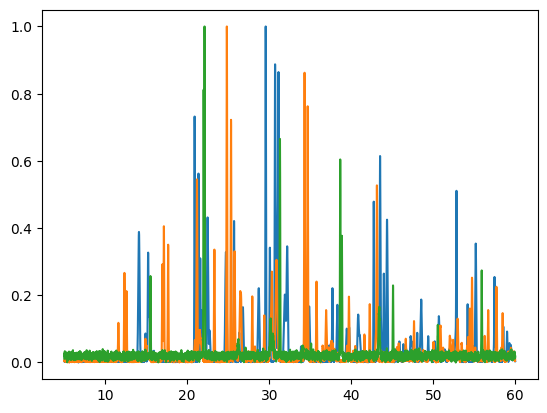

In [4]:
Xs, Ys, element_list, formula_list = dataloader.load_data(batch_size=3, max_n_mix=5,
                                                                 noise_sigma_list=np.logspace(-4,-2,num=101))
for i in range(len(element_list)):
    plt.plot(np.arange(5.00, 60.01, 0.01), Xs[i])
    print(element_list[i], formula_list[i], Ys[i])

# Train

In [5]:
visual_embedding_dim = 5
configuration = VisualBertConfig(visual_embedding_dim=visual_embedding_dim, hidden_size=int(Xs.shape[1]/visual_embedding_dim), 
                                 num_attention_heads=1, num_labels=Ys.shape[1])
print(configuration)
model = VisualBertForQuestionAnswering(configuration).to('cuda')
optimizer = AdamW(model.parameters(), lr=1e-5)

VisualBertConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "bypass_transformer": false,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1100,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32": "LABEL_32",
    "33": "LABEL_33",
    "34": "LABEL_34",
    "35": "LABEL_35",
    

In [6]:
train_losses = []

In [7]:
num_of_epochs = 100000
batch_size = 8
np.set_printoptions(precision=3)

model.train()

for i in range(num_of_epochs):
    Xs, Ys, element_list, formula_list = dataloader.load_data(batch_size=batch_size, max_n_mix=5,
                                                                     noise_sigma_list=np.logspace(-4,-2,num=101))
    Xs = Xs[:,:-1,:].reshape((Xs.shape[0],int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    
    X_prompts = []
    for j in range(batch_size):
        random.shuffle(element_list[j])
        X_prompts.append(' '.join(element_list[j]))

    visual_embeds = torch.from_numpy(Xs).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
            
    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )
    
    labels = torch.from_numpy(np.array(Ys)).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), labels=labels.to('cuda'))
    logits = outputs.logits
    weight = labels*100+1
    loss = torch.nn.BCEWithLogitsLoss(weight=weight.to('cuda'))(logits, labels.to('cuda'))
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    print('{}\t{:.5f}\t{}\t{}'.format(i+1, np.array(loss.detach().cpu()), np.array(labels).argmax(-1), 
                                     np.array(logits.argmax(-1).detach().cpu())))
#     break
    train_losses.append(np.array(loss.detach().cpu()))
    
    if (i+1)%5000 == 0:
        model.save_pretrained(os.path.join(folder, '{}'.format(i+1)), from_pt=True) 

1	9.09867	[ 21  78  39  73   0   6  56 130]	[ 66  81   4 110   4  81  81 116]


# Test

In [4]:
model = VisualBertForQuestionAnswering.from_pretrained(r'').to('cuda')
optimizer = AdamW(model.parameters(), lr=1e-5)
softmax = torch.nn.Softmax(dim=1)

# ---- No use ----

In [6]:
train_losses = []

In [10]:
num_of_epochs = 1
batch_size = 20
Y_labels = ['N', 'P', 'K']
Y_criterion = [2.35, 0.27, 1]

model.train()

for i in range(num_of_epochs):
    Xs, Ys, prompts = dataloader.load_data(batch_size=batch_size, labels=Y_labels, KFold_i=2, image_size=64, classification=False)

    Xs = Xs.reshape(Xs.shape[0],Xs.shape[1],-1)
    visual_embeds = torch.from_numpy(Xs).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    X_prompts = []
    Y_Ys = np.zeros((batch_size,len(Y_labels)*2))
    for j in range(batch_size):
        label = np.random.choice(Y_labels)
        X_prompts.append(prompts[label])
        if Ys[label][j][0] < Y_criterion[Y_labels.index(label)]:
            Y_Ys[j,Y_labels.index(label)*2] += 1
        else:
            Y_Ys[j,Y_labels.index(label)*2+1] += 1
            
    inputs = tokenizer(X_prompts, return_tensors="pt")
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )
    
    labels = torch.from_numpy(np.array(Y_Ys)).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), labels=labels.to('cuda'))
    loss = outputs.loss
    logits = outputs.logits

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    print('{}\t{:.5f}\t{}\t{}'.format(i+1, np.array(loss.detach().cpu()), np.array(labels).argmax(-1), 
                                     np.array(logits.argmax(-1).detach().cpu())))
#     break
    train_losses.append(np.array(loss.detach().cpu()))
    
    if (i+1)%5000 == 0:
        model.save_pretrained(r"K:\Python\MIT\ML\TimeSformer\20240609_NPK_lr1e5\{}".format(i+1), from_pt=True) 

1	0.05596	[5 1 1 1 5 3 4 0 5 3 1 3 1 3 3 1 5 5 0 3]	[5 1 1 1 5 3 5 0 5 3 1 3 1 3 3 1 5 5 0 3]


C:\Users\axvcb\AppData\Local\Temp\ipykernel_148044\4127019395.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


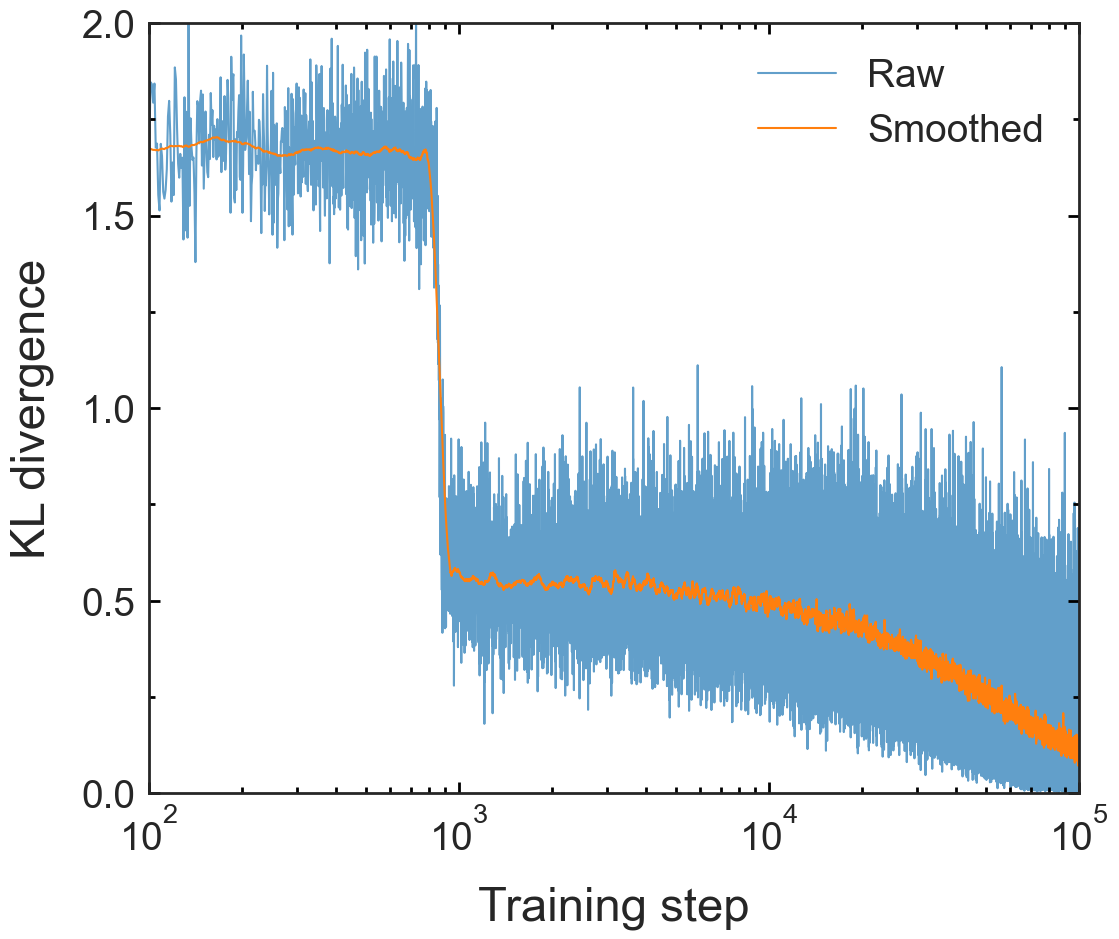

In [11]:
folder = r'K:\Python\MIT\ML\TimeSformer\20240609_NPK_lr1e5\100000'
np.savetxt(folder+r"\training_loss.txt", train_losses)
smoothed = savgol_filter(np.array(train_losses),window_length=201,polyorder=3)

load_plt_setting()

fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(np.array(train_losses),zorder=-10, alpha=0.7, label='Raw')
ax.plot(smoothed, label='Smoothed')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax.axes.set_xlim([100,100000])
ax.axes.set_ylim([0,2])
ax.set_xscale('log')

ax.set_xlabel(r'Training step', labelpad=20, fontsize=34)
ax.set_ylabel(r'KL divergence', labelpad=20, fontsize=34)
plt.legend(loc="upper right",fontsize=28)

plt.savefig(folder+r"\training_loss.svg", format='svg', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(folder+r"\training_loss.png", format='png', dpi=300, transparent=True, bbox_inches='tight')

# Attention

In [104]:
index = indexes[-2]
test = 'K'
tests = ['N', 'P', 'K']
_, _, prompts = dataloader.load_data(batch_size=1, labels=tests, KFold_i=2, image_size=64, classification=False)


sample_name = dataloader.data['Name'][index]
X = dataloader.data['X'][index]
X = X.reshape(360,X.shape[2],X.shape[3])
nans = np.isnan(X[0,:,:])
nancols = np.all(nans, axis=0)
nanrows = np.all(nans, axis=1)
firstcol = nancols.argmin()
firstrow = nanrows.argmin()
lastcol = len(nancols)-nancols[::-1].argmin()
lastrow = len(nanrows)-nanrows[::-1].argmin()
X = X[:,firstrow+20:lastrow-20,firstcol:lastcol-80]
X = X[:,:,:]

Y_map = np.zeros((X.shape[1],X.shape[2]))
Y_weight = np.zeros((X.shape[1],X.shape[2]))
print('total points: ', (X.shape[1]-64)*(X.shape[2]-64))

Ys = np.zeros((1,6))
X_prompts = []
X_prompts.append(prompts[test])

total points:  21480


(-0.5, 242.5, 183.5, -0.5)

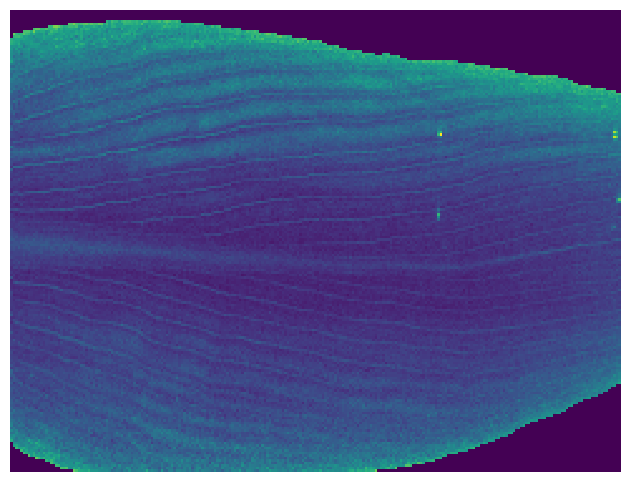

In [43]:
fig, ax = plt.subplots(figsize = (12,6))
# ax.matshow(X[210,10:74,10:74])
ax.matshow(X[0,:,:])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axis('off')

In [105]:
i = 10
j = 10

Xs = np.expand_dims(X,0)[:,:,i:i+64,j:j+64]
Xs = Xs.reshape(Xs.shape[0],Xs.shape[1],-1)

visual_embeds = torch.from_numpy(Xs).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
inputs = tokenizer(X_prompts, return_tensors="pt")
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)
labels = torch.from_numpy(Ys).to(dtype=torch.float32)
outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
logits = outputs.logits
Y_pred = (np.array(logits.argmax(-1).detach().cpu())[0]-tests.index(test)*2)

In [53]:
inputs['input_ids'].shape

torch.Size([1, 10])

In [52]:
X.shape

(360, 184, 243)

In [47]:
folder = r'K:\Python\MIT\ML\TimeSformer\20240609_NPK_lr1e5\100000'

for i in range(12):
    
    load_plt_setting()
    fig, ax = plt.subplots(figsize=(12, 10))
    mat = ax.matshow(np.array(outputs.attentions[0].detach().cpu())[0,i,:,:], cmap='viridis')
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 5]))
    ax.tick_params(axis='both', direction='out', length=8, width=3, pad=5)
    ax.tick_params(axis='both', which='minor', direction='out', length=4, width=3, pad=5)
    ax.xaxis.set_ticks_position('bottom')

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=26)
    cbar.ax.set_ylabel('Attention weight (a.u.)',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)
    plt.xlabel('Wavelength index', labelpad=25)
    plt.ylabel('Wavelength index', labelpad=25)
    
    plt.savefig(folder+r"\SelfAttention_{}.svg".format(i), format='svg', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(folder+r"\SelfAttention_{}.png".format(i), format='png', dpi=300, transparent=True, bbox_inches='tight')
    
    plt.close("all")

C:\Users\axvcb\AppData\Local\Temp\ipykernel_25636\4127019395.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
C:\Users\axvcb\AppData\Local\Temp\ipykernel_25636\4127019395.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
C:\Users\axvcb\AppData\Local\Temp\ipykernel_25636\4127019395.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will

C:\Users\axvcb\AppData\Local\Temp\ipykernel_25636\4127019395.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


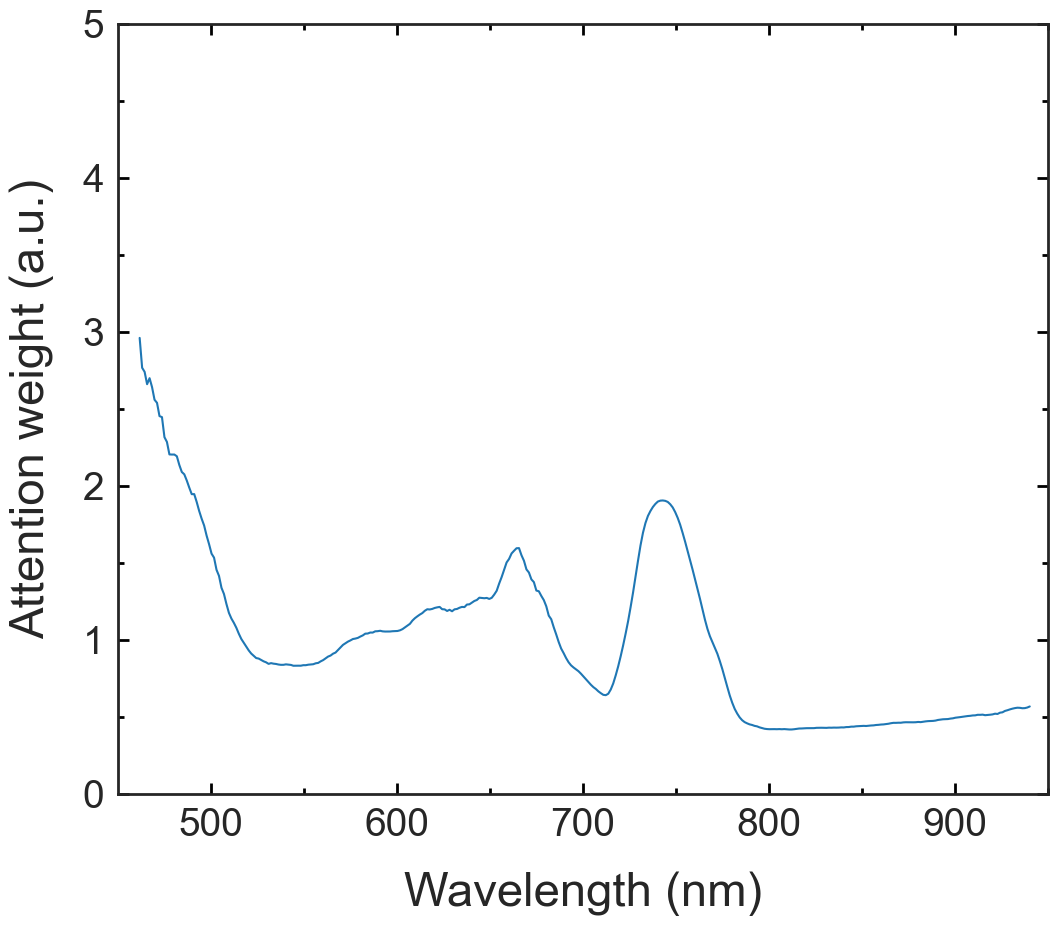

In [67]:
wav = np.linspace(461.7562, 461.7562+363*1.3330, 364)[:-4]

for i in range(12):
    Y = np.array(outputs.attentions[0].detach().cpu())[0,i,10:,10:]

    load_plt_setting()

    fig, ax = plt.subplots(figsize=(12, 10))

    ax.plot(wav, np.sum(Y, axis=0))

    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax.axes.set_xlim([450,950])
    ax.axes.set_ylim([0,5])
    # ax.set_xscale('log')

    ax.set_xlabel(r'Wavelength (nm)', labelpad=20, fontsize=34)
    ax.set_ylabel(r'Attention weight (a.u.)', labelpad=20, fontsize=34)

    plt.savefig(folder+r"\SelfAttention_{}_linear.svg".format(i), format='svg', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(folder+r"\SelfAttention_{}_linear.png".format(i), format='png', dpi=300, transparent=True, bbox_inches='tight')


C:\Users\axvcb\AppData\Local\Temp\ipykernel_25636\4127019395.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
C:\Users\axvcb\AppData\Local\Temp\ipykernel_25636\2216973128.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','[CLS]','Is', 'this', 'corn', 'leaf', 'lack', 'of', 'Nitrogen', '?', '[SEP]'], rotation=35)
C:\Users\axvcb\AppData\Local\Temp\ipykernel_25636\4127019395.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('se

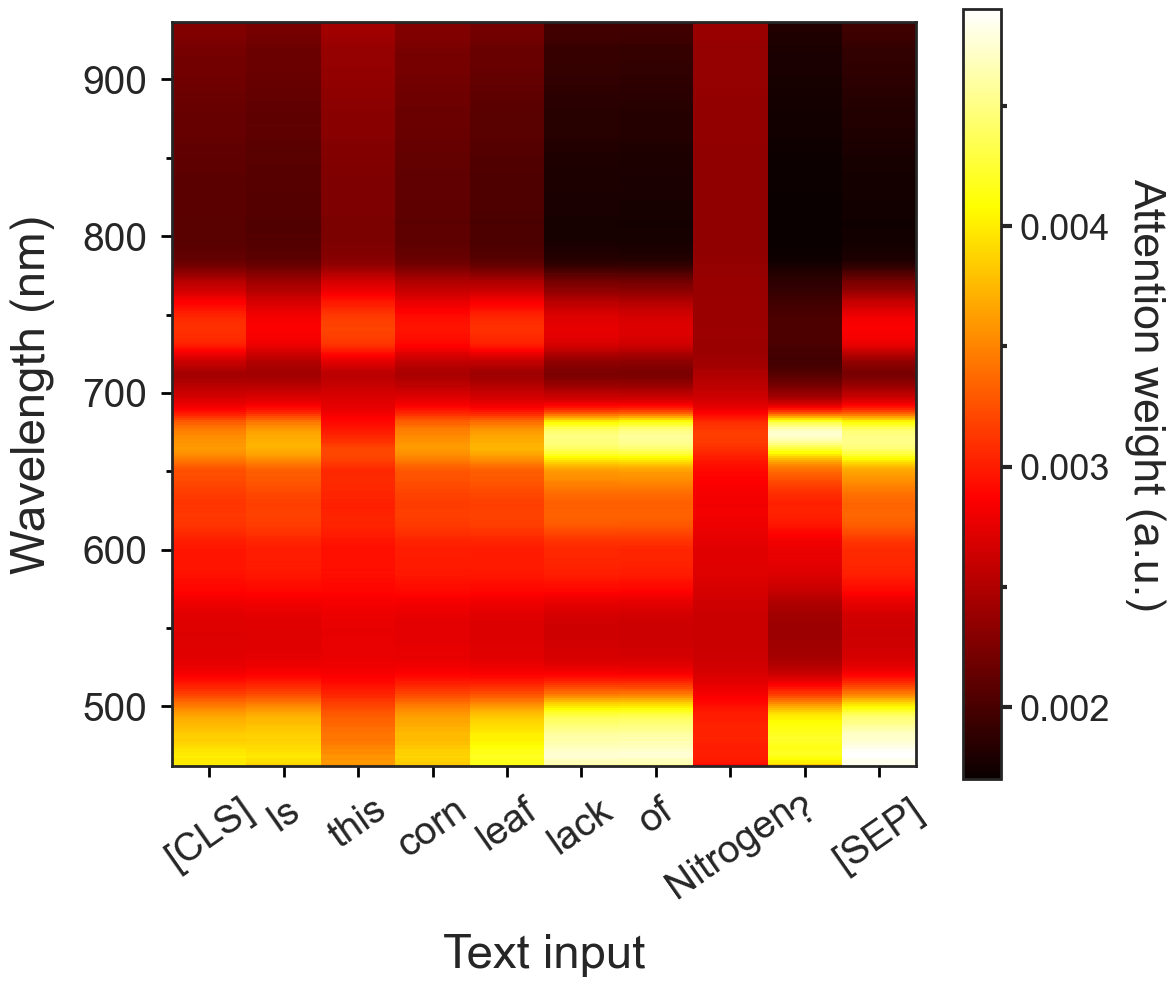

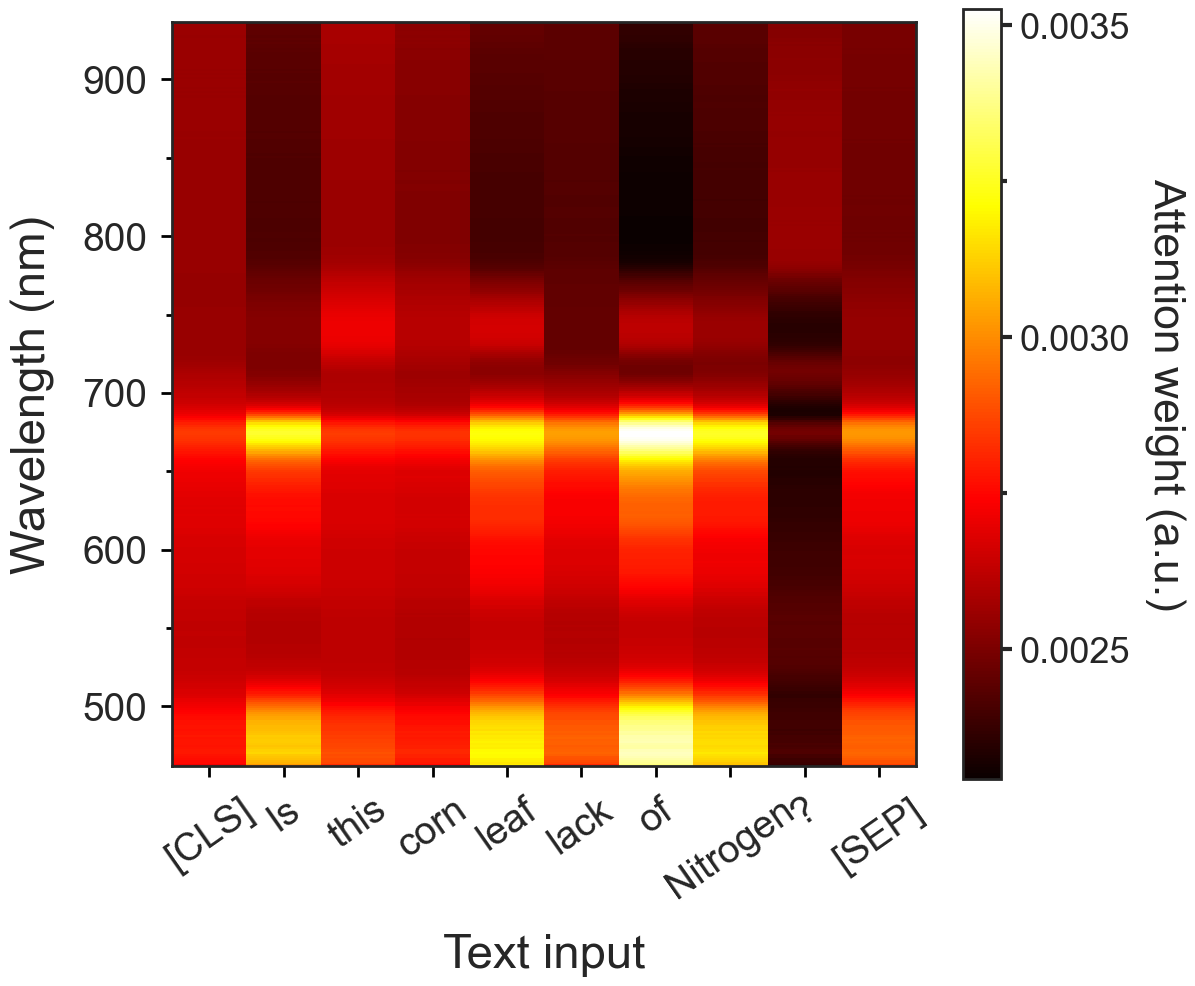

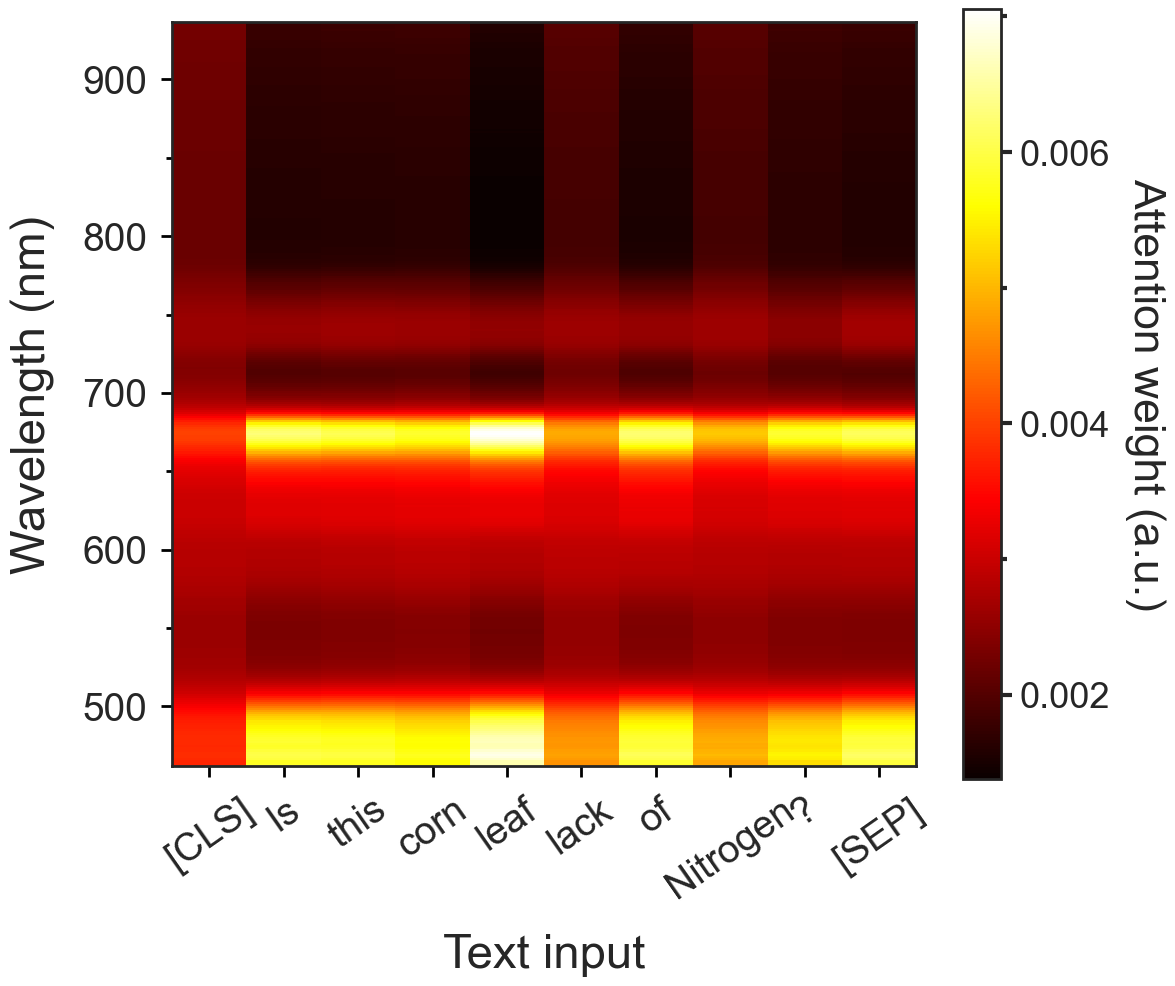

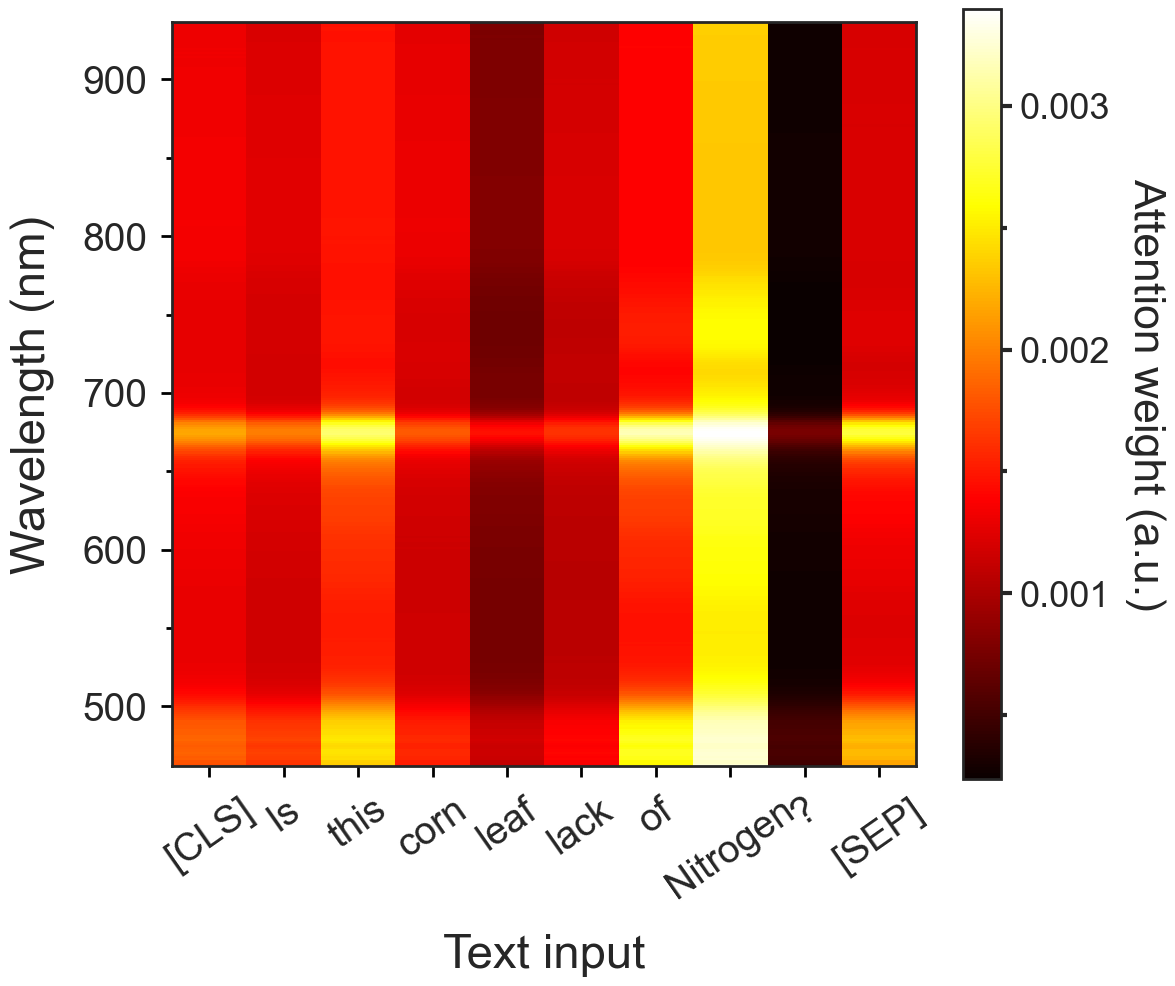

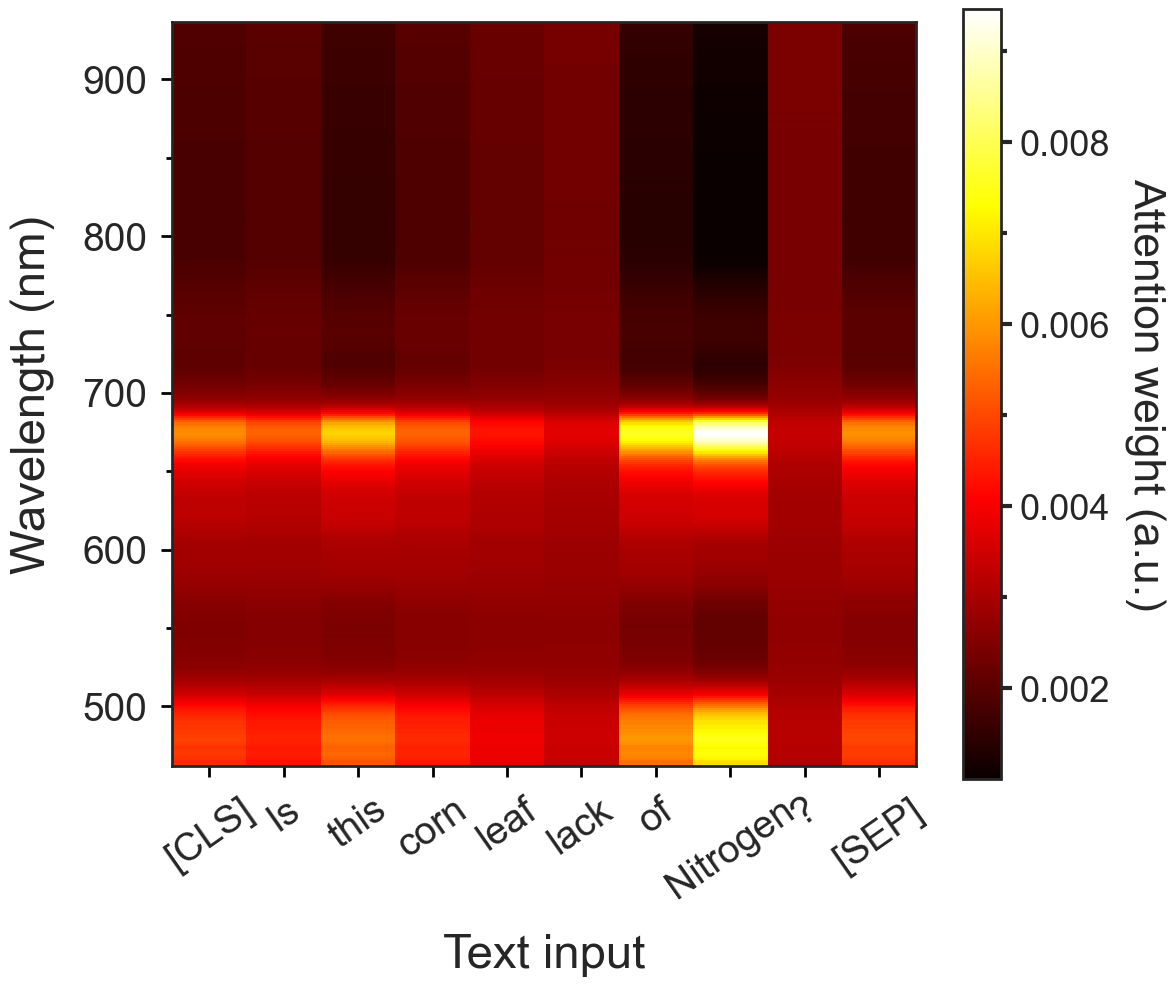

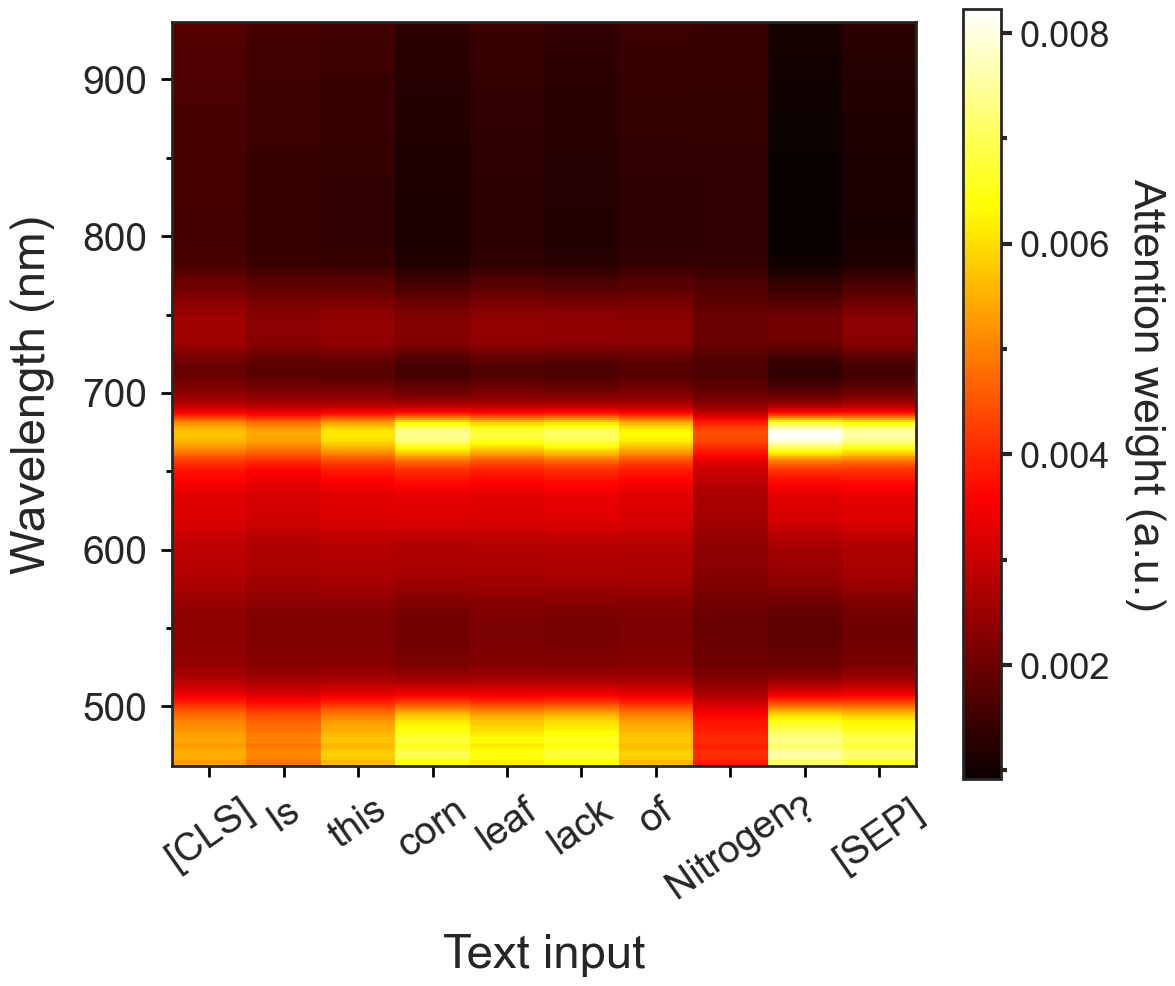

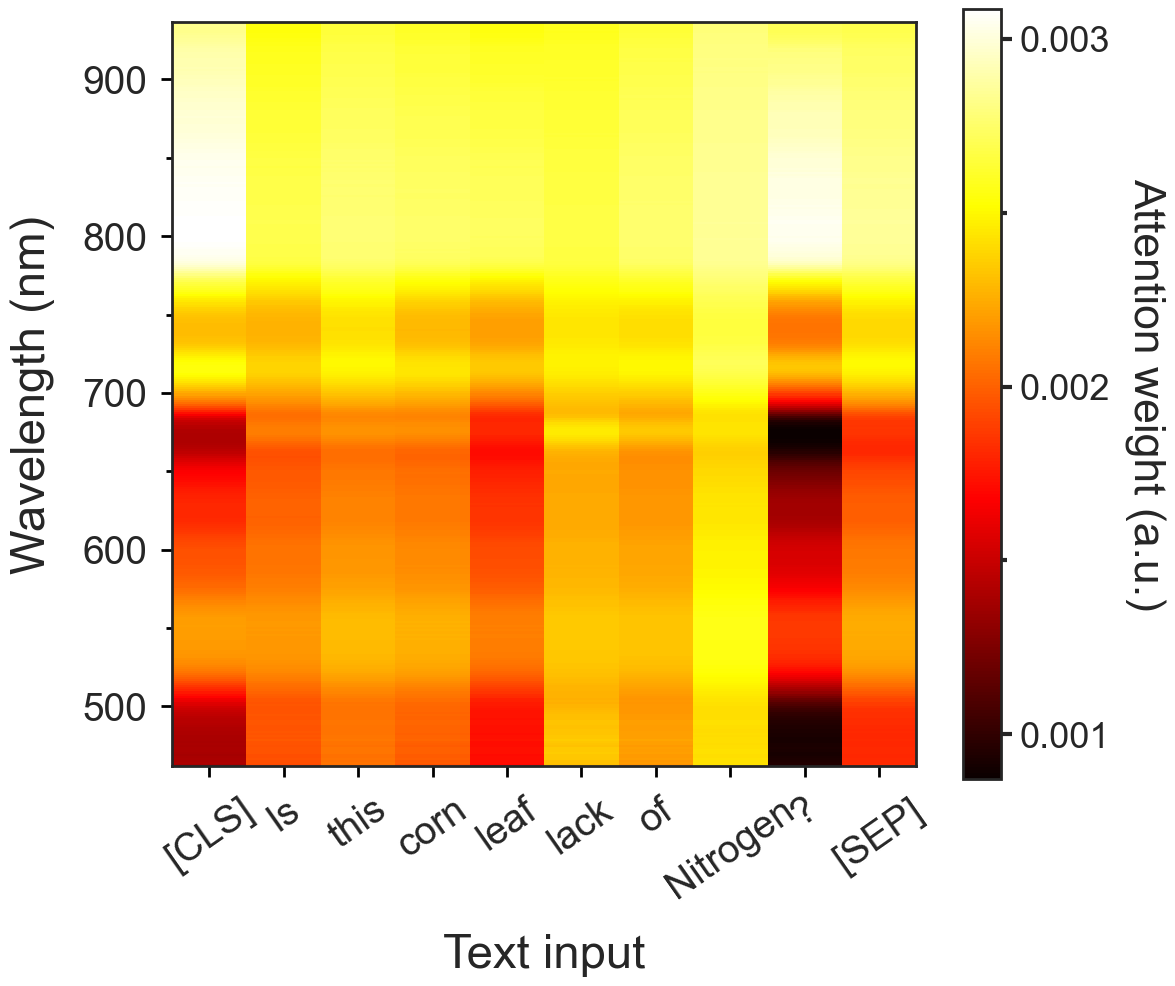

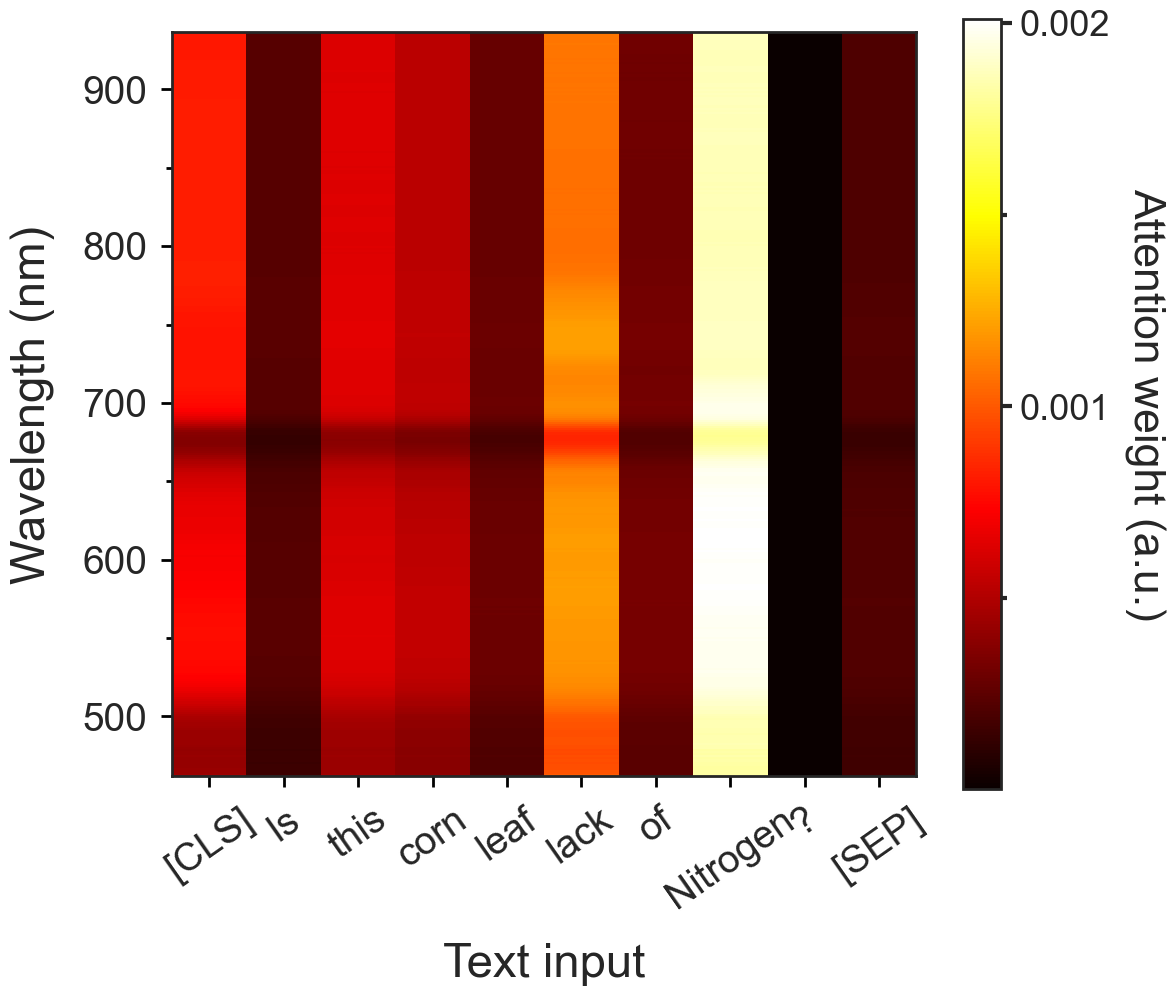

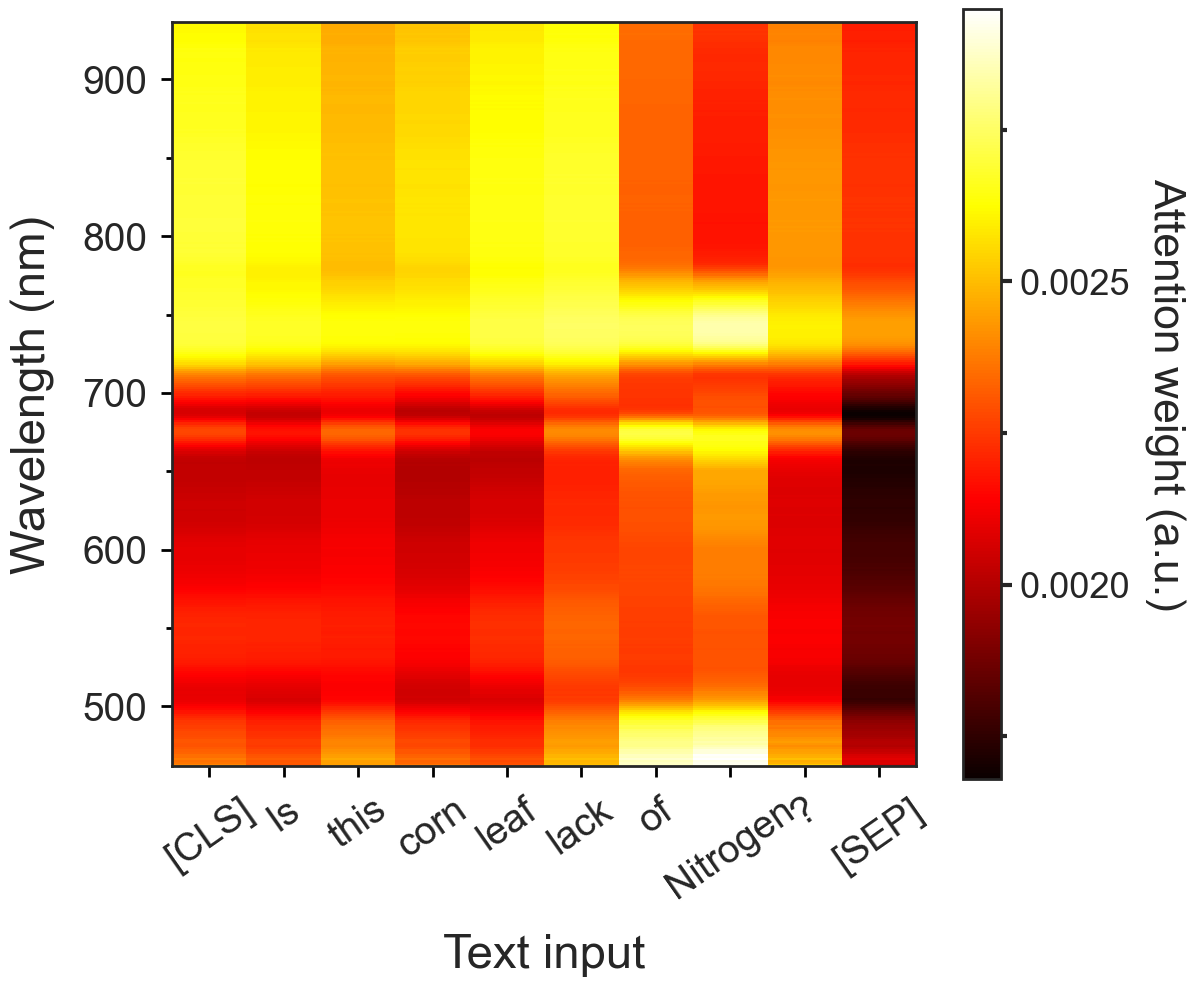

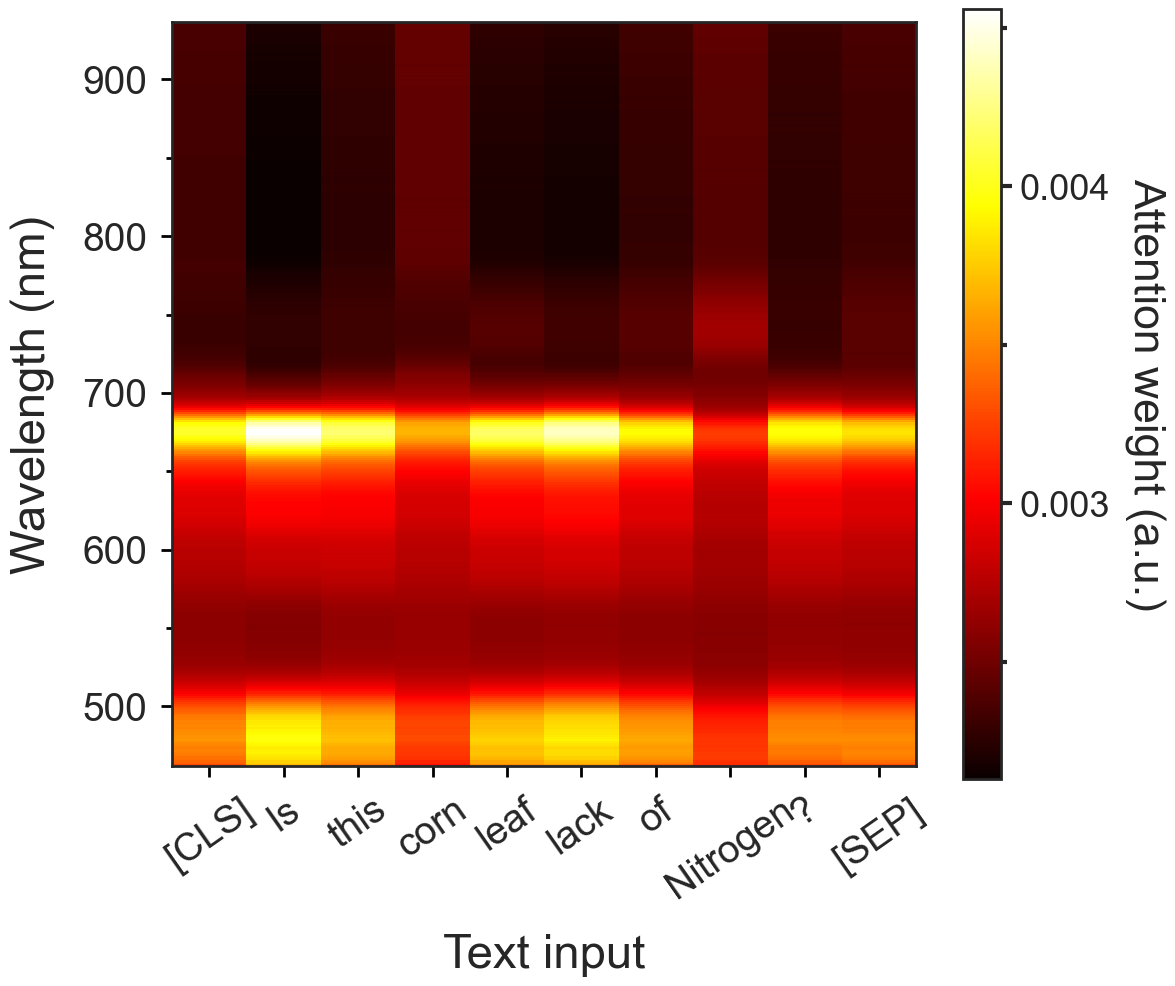

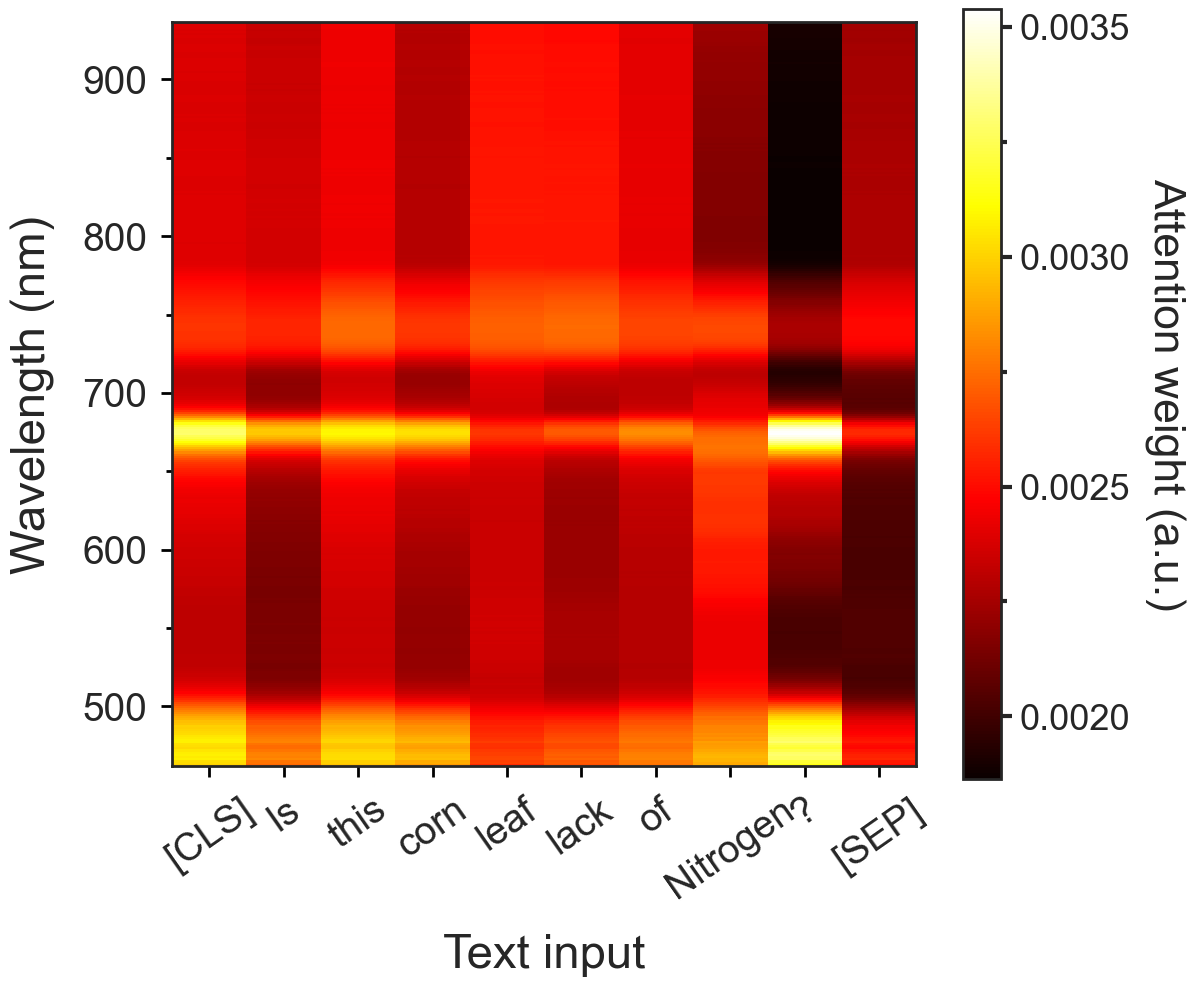

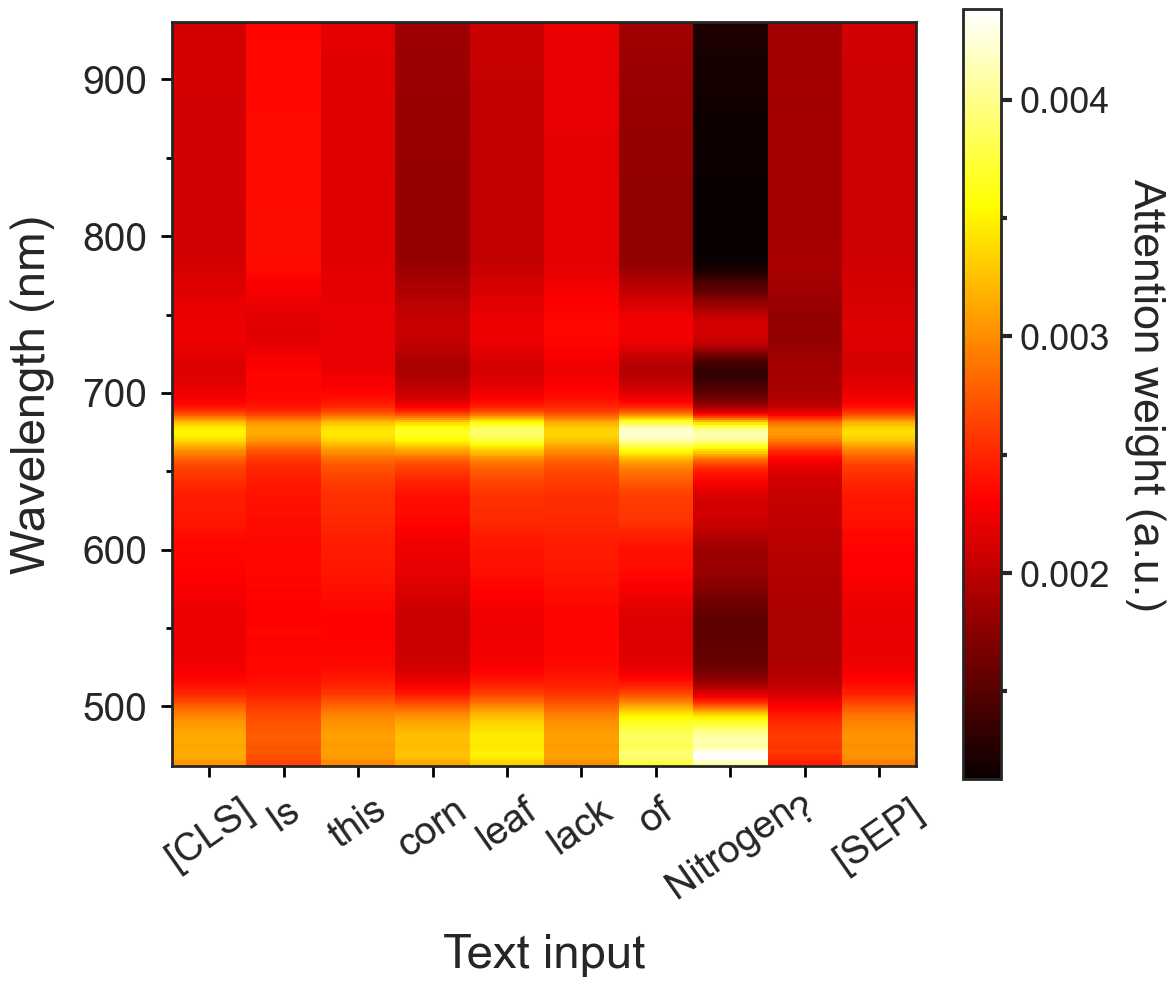

In [88]:
wav = np.linspace(461.7562, 461.7562+363*1.3330, 364)[:-4]

for i in range(12):
    Y = np.array(outputs.attentions[0].detach().cpu())[0,i,:10,10:]
    extent = [0.5,10.5,wav[0],wav[-4]]

    load_plt_setting()

    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(np.rot90(Y), extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2]), cmap='hot')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(['','[CLS]','Is', 'this', 'corn', 'leaf', 'lack', 'of', 'Nitrogen', '?', '[SEP]'], rotation=35)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=12, steps=[1, 2, 5, 10]))
    # ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
    # ax.axes.set_xlim([450,950])
    # ax.axes.set_ylim([0,5])
    # # ax.set_xscale('log')

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=26)
    cbar.ax.set_ylabel('Attention weight (a.u.)',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)


    ax.set_xlabel(r'Text input', labelpad=20, fontsize=34)
    ax.set_ylabel(r'Wavelength (nm)', labelpad=20, fontsize=34)

    plt.savefig(folder+r"\SelfAttention_{}_text.svg".format(i), format='svg', dpi=300, transparent=True, bbox_inches='tight')
    plt.savefig(folder+r"\SelfAttention_{}_text.png".format(i), format='png', dpi=300, transparent=True, bbox_inches='tight')


C:\Users\axvcb\AppData\Local\Temp\ipykernel_25636\4127019395.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
C:\Users\axvcb\AppData\Local\Temp\ipykernel_25636\1879248630.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','[CLS]','Is', 'this', 'corn', 'leaf', 'lack', 'of', 'Potassium', '?', '[SEP]'], rotation=35)
C:\Users\axvcb\AppData\Local\Temp\ipykernel_25636\1879248630.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','[CLS]','Is', 'this', 'corn', 'leaf', 'lack', 'of', 'Potassium', '?', '[SEP]'])


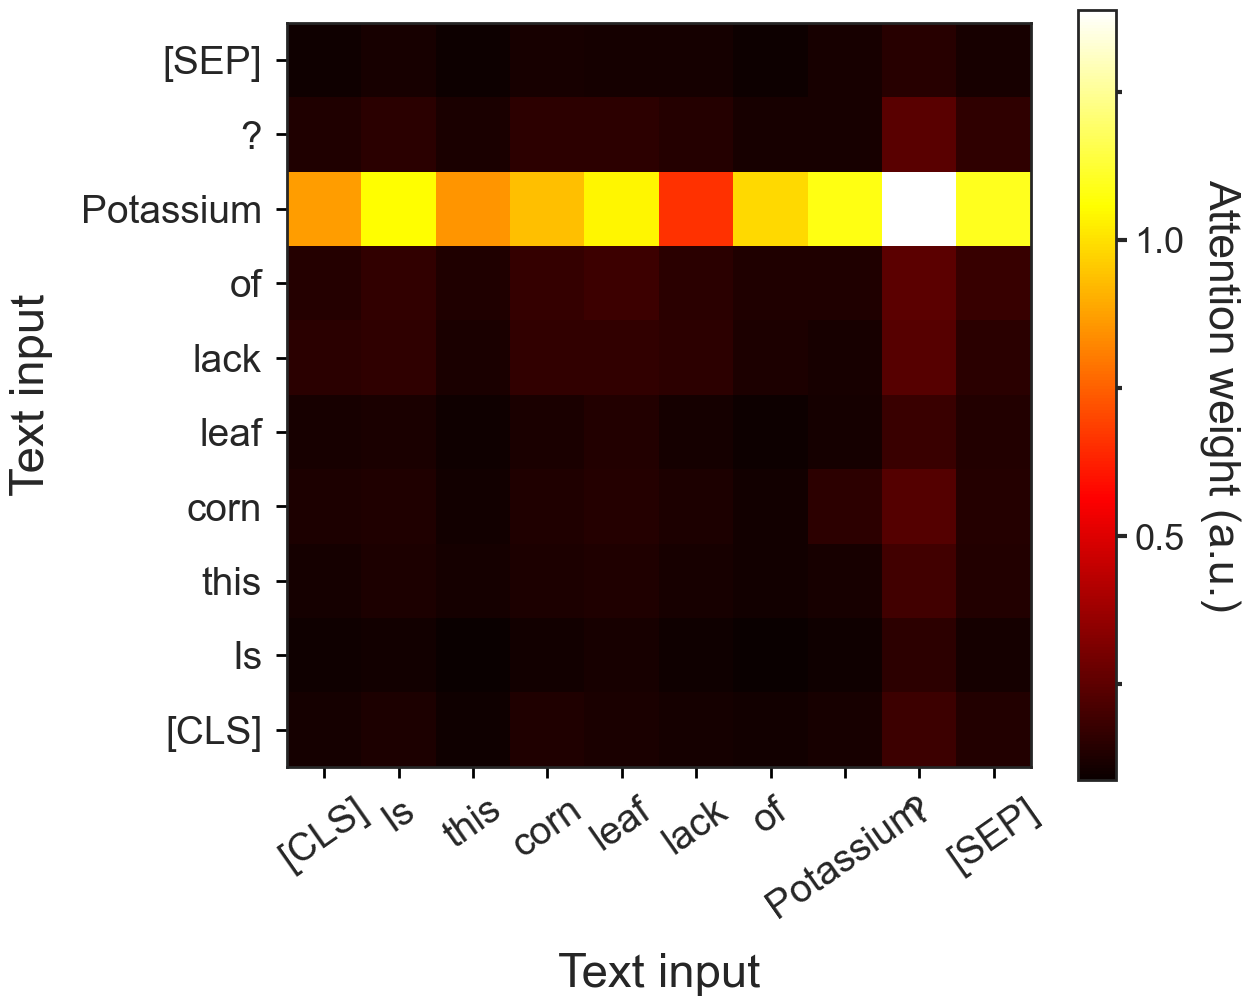

In [106]:
wav = np.linspace(461.7562, 461.7562+363*1.3330, 364)[:-4]


Y = np.sum(np.array(outputs.attentions[0].detach().cpu())[0,:,:10,:10],axis=0)
extent = [0.5,10.5,0.5,10.5]

load_plt_setting()

fig, ax = plt.subplots(figsize=(12, 10))

mat = ax.matshow(np.rot90(Y), extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2]), cmap='hot')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(['','[CLS]','Is', 'this', 'corn', 'leaf', 'lack', 'of', 'Potassium', '?', '[SEP]'], rotation=35)
ax.set_yticklabels(['','[CLS]','Is', 'this', 'corn', 'leaf', 'lack', 'of', 'Potassium', '?', '[SEP]'])
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=12, steps=[1, 2, 5, 10]))
# ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=12, steps=[1, 2, 5, 10]))
# ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
# ax.axes.set_xlim([450,950])
# ax.axes.set_ylim([0,5])
# # ax.set_xscale('log')

cbar = plt.colorbar(mat)
cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=26)
cbar.ax.set_ylabel('Attention weight (a.u.)',labelpad=40, rotation=-90)
cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)


ax.set_xlabel(r'Text input', labelpad=20, fontsize=34)
ax.set_ylabel(r'Text input', labelpad=20, fontsize=34)

plt.savefig(folder+r"\SelfAttention_sum_text_K.svg", format='svg', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(folder+r"\SelfAttention_sum_text_K.png", format='png', dpi=300, transparent=True, bbox_inches='tight')
